# 2. Global Model Fitting

In this notebook, we will fit the growth models to the aggregated, scaled, daily-mean data. This gives us a "global" set of parameters that describe the average growth pattern of the entire experiment.

These global parameters are crucial as they will be used as the **initial guesses (q0)** for the optimization on each individual plant in the next step.

## 2.1 Imports and Setup

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib # For saving the scaler
from scipy.optimize import minimize

# Add the parent directory to the system path to allow imports from src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import our custom functions
from src.data_processing import load_data, preprocess_data, get_daily_means, apply_scaling
from src.visualization import plot_global_models
from src.fitting import (cost_linear, cost_logistic, cost_ricker, 
                         cost_exponential, cost_gvb, cost_hill)

# Set plot styles
%matplotlib inline
sns.set_context('talk')
sns.set_style('whitegrid')

## 2.2 Load and Process Data

First, we load and preprocess the data, just as in Notebook 01. Then, we aggregate it into daily means.

In [25]:
# Define file paths
FEATURES_PATH = '../data/5.25.2024_CBI.0010_York_Poplar_RGB.side_features.csv'
BARCODE_PATH = '../data/barcodes--5.25.2024_CBI.0010_York_Poplar.csv'

# Load and preprocess
data_df, barcode_df = load_data(FEATURES_PATH, BARCODE_PATH)
merged_df = preprocess_data(data_df, barcode_df, experiment_start_str='2024-05-26 00:00:00')

# Get daily means
daily_means_df = get_daily_means(merged_df)

print("Daily means data shape:", daily_means_df.shape)
daily_means_df.head()

Daily means data shape: (31, 54)


,Date,area,convex_hull_area,solidity,perimeter,width,height,longest_path,center_of_mass_x,center_of_mass_y,...,saturation_mean,saturation_var,saturation_max,value_mean,value_var,value_min,value_max,Replication,Random,Days_Since_2024_05_26
0,2024-05-26,211505.937500,1.109705e+06,0.202121,15968.962972,1041.517857,1510.303571,10720.651786,1627.378287,3986.878796,...,37.017112,1.953993e-16,98.918036,45.022434,1.015061e-17,16.781875,94.415089,4.330357,260.866071,0
1,2024-05-27,203368.729730,1.169632e+06,0.182014,17314.552649,1054.774775,1565.540541,10974.441441,1649.349984,3941.206348,...,37.310715,-7.092625e-16,99.311081,43.177766,-3.328669e-17,17.106577,93.803333,4.315315,239.837838,1
2,2024-05-28,229601.685185,1.278929e+06,0.185214,18325.850501,1114.018519,1652.546296,11653.472222,1656.513366,3889.613925,...,36.434324,5.131698e-17,99.320926,43.601481,-1.921097e-16,16.604444,93.979815,4.611111,226.527778,2
3,2024-05-29,230589.219298,1.256784e+06,0.197189,17350.366433,1079.991228,1683.184211,11883.754386,1640.296909,3820.973777,...,37.091872,-2.792308e-16,99.367018,43.212816,9.473903e-17,16.642719,95.084386,4.578947,201.184211,3
4,2024-05-30,244741.723214,1.241352e+06,0.213143,17139.066793,1073.883929,1634.741071,11463.133929,1633.709576,3882.970853,...,37.265996,-3.362390e-16,99.264643,43.899982,-2.157005e-16,16.474018,94.138482,4.330357,260.866071,4


## 2.3 Scale Data

We will apply a `MinMaxScaler` to the daily mean data. This scales all features (like 'area') to be between 0 and 1, which helps the optimization algorithms converge more reliably.

We will **save the fitted scaler object** (`scaler_obj`) because we must apply the *exact same scaling* to the individual plant data in the next notebook.

In [ ]:
# Apply MinMaxScaler
dat_scaled, columns_to_scale, scaler_obj = apply_scaling(daily_means_df, scaler_name="MinMaxScaler")

# --- Save the list of columns that were scaled ---
COLUMNS_SAVE_PATH = '../results/data/scaled_columns_list.joblib'
joblib.dump(columns_to_scale, COLUMNS_SAVE_PATH)
# -----------------------------------------------------------

# Save the scaler object for later use
os.makedirs('../results/data', exist_ok=True)
SCALER_SAVE_PATH = '../results/data/global_minmax_scaler.joblib'
joblib.dump(scaler_obj, SCALER_SAVE_PATH)


print(f"Scaler object saved to '{SCALER_SAVE_PATH}'")
print(f"List of scaled columns saved to '{COLUMNS_SAVE_PATH}'")
print("\nColumns that were scaled:")
print(columns_to_scale)
dat_scaled.head()

Scaler object saved to '../results/data/global_minmax_scaler.joblib'
List of scaled columns saved to '../results/data/scaled_columns_list.joblib'

Columns that were scaled:
['area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass_x', 'center_of_mass_y', 'convex_hull_vertices', 'ellipse_center_x', 'ellipse_center_y', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity', 'blue_mean', 'blue_var', 'blue_min', 'blue_max', 'green_mean', 'green_var', 'green_min', 'green_max', 'red_mean', 'red_var', 'red_min', 'red_max', 'lightness_mean', 'lightness_var', 'lightness_min', 'lightness_max', 'green_red_mean', 'green_red_var', 'green_red_min', 'green_red_max', 'blue_yellow_mean', 'blue_yellow_var', 'blue_yellow_min', 'blue_yellow_max', 'hue_mean', 'hue_var', 'hue_max', 'saturation_mean', 'saturation_var', 'saturation_max', 'value_mean', 'value_var', 'value_min', 'value_max']


,Date,area,convex_hull_area,solidity,perimeter,width,height,longest_path,center_of_mass_x,center_of_mass_y,...,saturation_mean,saturation_var,saturation_max,value_mean,value_var,value_min,value_max,Replication,Random,Days_Since_2024_05_26
0,2024-05-26,0.015648,0.000000,0.366936,0.000000,0.000000,0.000000,0.000000,0.010770,1.000000,...,0.940867,9.046617e-16,0.194800,1.000000,1.070889e-15,0.885033,0.135145,4.330357,260.866071,0
1,2024-05-27,0.000000,0.022171,0.107203,0.057790,0.021640,0.029019,0.019880,0.300950,0.955384,...,1.000000,0.000000e+00,0.511699,0.156766,1.027452e-15,1.000000,0.000000,4.315315,239.837838,1
2,2024-05-28,0.050445,0.062606,0.148538,0.101222,0.118346,0.074729,0.073071,0.395556,0.904984,...,0.823490,7.605795e-16,0.519637,0.350455,8.686291e-16,0.822210,0.038987,4.611111,226.527778,2
3,2024-05-29,0.052344,0.054413,0.303234,0.059328,0.062802,0.090825,0.091110,0.181386,0.837931,...,0.955924,4.300316e-16,0.556799,0.172788,1.155478e-15,0.835762,0.283001,4.578947,201.184211,3
4,2024-05-30,0.079559,0.048704,0.509322,0.050253,0.052833,0.065375,0.058161,0.094387,0.898495,...,0.990993,3.730235e-16,0.474258,0.486906,8.450383e-16,0.776030,0.074039,4.330357,260.866071,4


## 2.4 Run Global Optimization

Now we fit all six models to the scaled, aggregated data (`dat_scaled`).

In [ ]:
# Prepare data for optimization
dd = dat_scaled["Days_Since_2024_05_26"].to_numpy()
area = dat_scaled["area"].to_numpy()

# Store results
global_params = {}

# Define initial guesses (q0) and bounds for each model
# 1. Linear
q0_linear = [0.01, 0.01]
bounds_linear = ((0, 1), (0, 1))
lin_opt = minimize(cost_linear, q0_linear, args=(dd, area), method='L-BFGS-B', bounds=bounds_linear)
global_params['linear'] = lin_opt.x
print("Linear Optimal:", lin_opt.x)

# 2. Logistic
q0_logistic = [0.01, 0.1, 1]
bounds_logistic = ((0, 1), (0, 1), (0, 1.5))
log_opt = minimize(cost_logistic, q0_logistic, args=(dd, area), method='L-BFGS-B', bounds=bounds_logistic)
global_params['logistic'] = log_opt.x
print("Logistic Optimal:", log_opt.x)

# 3. Ricker
q0_ricker = [0.01, 0.01, 1]
bounds_ricker = ((0, 1), (0, 1), (0, 1.5))
ricker_opt = minimize(cost_ricker, q0_ricker, args=(dd, area), method='L-BFGS-B', bounds=bounds_ricker)
global_params['ricker'] = ricker_opt.x
print("Ricker Optimal:", ricker_opt.x)

# 4. Exponential
q0_exp = [0.01, 0.1]
bounds_exp = ((0, 1), (0, 1))
exp_opt = minimize(cost_exponential, q0_exp, args=(dd, area), method='L-BFGS-B', bounds=bounds_exp)
global_params['exponential'] = exp_opt.x
print("Exponential Optimal:", exp_opt.x)

# 5. Generalized von Bertalanffy (GVB) (FIXED)
# q = [m0 (start), k (rate), f (shape), A (asymptote)]
# The initial guess (q0) is fine, but the bounds are too loose.
q0_gvb = [0.01, 0.15, 0.29, .9161]
bounds_gvb = ((0, 5),       # m0 (start time)
              (0.01, 2),    # k (rate) must be positive
              (0.01, 0.99), # f (shape) cannot be 1 (causes div by zero)
              (0.8, 1.5))   # A (asymptote) must be near 1
gvb_opt = minimize(cost_gvb, q0_gvb, args=(dd, area), method='L-BFGS-B', bounds=bounds_gvb)
global_params['gen_vb'] = gvb_opt.x
print("Gen. VB Optimal:", gvb_opt.x)

# 6. Hill (FIXED)
# q = [a (min), b (slope), c (EC50), d (max)]
# We need to give it a good starting guess from looking at the graph.
# a (min) is near 0.
# b (slope) is probably > 1. Let's guess 2.
# c (EC50/half-max) is around 20-25 days.
# d (max) is near 1.
q0_hill = [0.0, 2.0, 22.0, 1.0]
bounds_hill = ((0, 0.2),      # a (min) must be near 0
               (0.1, 10),    # b (slope) must be positive
               (10, 30),     # c (EC50) must be within the experiment time
               (0.8, 1.5))   # d (max) must be near 1
hill_opt = minimize(cost_hill, q0_hill, args=(dd, area), method='L-BFGS-B', bounds=bounds_hill)
global_params['hill'] = hill_opt.x
print("Hill Optimal:", hill_opt.x)

Linear Optimal: [0.01166458 0.03057772]
Logistic Optimal: [0.07142765 0.17113605 0.95389661]
Ricker Optimal: [0.24599281 0.0581706  1.3494951 ]
Exponential Optimal: [0.20159136 0.05078041]
Gen. VB Optimal: [0.03064216 0.0943545  0.28968067 0.90373172]
Hill Optimal: [ 0.          1.58652483 25.0781721   1.48335677]


c:\Users\katie\OneDrive - East Tennessee State University\School\Data Saplings Organized\src\models.py:69: RuntimeWarning: divide by zero encountered in divide
  y = a + ((b - a) / (1 + ((c / t) ** d)))


## 2.5 Visualize Global Fits

Let's use our custom plotting function to visualize how well these globally-fit models match the daily mean data.

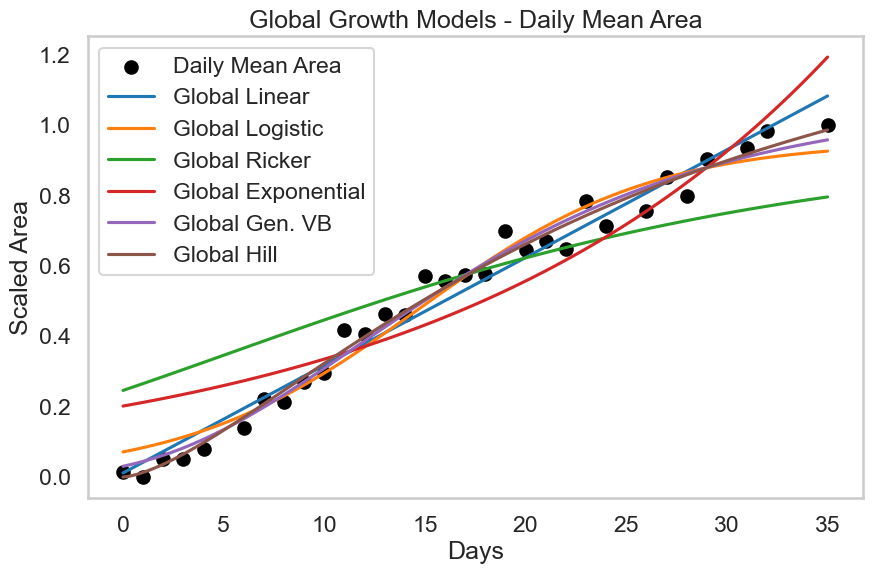

In [28]:
plot_global_models(dat_scaled, global_params)

## 2.6 Save Global Parameters

We will save these optimal parameters. They will be loaded in the next notebook to be used as the starting guesses for the per-plant fits.

In [29]:
# We can save the dictionary using joblib or pickle
param_save_path = '../results/data/global_optimal_params.joblib'
joblib.dump(global_params, param_save_path)

print(f"Global parameters saved to {param_save_path}")
print("\nGlobal Parameters:")
for model, params in global_params.items():
    print(f"- {model}: {np.round(params, 4)}")

Global parameters saved to ../results/data/global_optimal_params.joblib

Global Parameters:
- linear: [0.0117 0.0306]
- logistic: [0.0714 0.1711 0.9539]
- ricker: [0.246  0.0582 1.3495]
- exponential: [0.2016 0.0508]
- gen_vb: [0.0306 0.0944 0.2897 0.9037]
- hill: [ 0.      1.5865 25.0782  1.4834]


## 2.7 Next Steps

We have successfully:
1.  Loaded and aggregated the data.
2.  Scaled the data and saved the scaler.
3.  Fit all 6 models to the global data and saved the optimal parameters.

**Next step:** `03_plant_level_analysis.ipynb`, where we will fit the models to every single plant.